In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Q1: Multilinear Regression** : You need to find the position of a particle in 3D space (y1, y2, and y3) given a 10-dimensional feature vector. The features are readings from 10 sensors in the experiment environment. It is experimentally seen that the position of the particle depends linearly on these readings.

In [ ]:
# train_test_split
train_fraction = 0.9
validation_fraction = 0.0
test_fraction = 0.1

# for training
n_files_to_consider = 1 # total 50

# while training
batch_size = 32
lr = 0.001 # learning_rate

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/random/prnn_assign1/regression_data_multilinear_group_42_train.txt'
# drive link : https://drive.google.com/file/d/1jSmC64zycUY8akxlRu4DAzNsrNWPoPCX/view?usp=drive_link

In [ ]:
file_path = '/content/drive/My Drive/prnn_q5.txt'
df = np.loadtxt(file_path, delimiter='\t', skiprows=1)
np.random.shuffle(df)

In [ ]:
train_last_index = int(df.shape[0]*train_fraction)
validation_last_index = int(df.shape[0]*(train_fraction+validation_fraction))


train_df = df[:train_last_index, :]
train_x = df[:, :-3].T # shape = (10, n)
train_y = df[:, -3:].T # shape = (3, n)

validation_df = df[:validation_last_index, :]
test_df = df[validation_last_index:, :]
test_x = df[:, :-3].T# shape = (10, n)
test_y = df[:, -3:].T# shape = (3, n)

In [ ]:
print(df.shape, train_df.shape, validation_df.shape, test_df.shape)

(14000, 13) (12600, 13) (12600, 13) (1400, 13)


In [ ]:
def get_minibatch(batch_size = 32, x = None, y = None):
    siz = x.shape[1]
    for j in range(0,siz,batch_size):
        mini_x = x[:, j:j+batch_size] # shape = (10, n)
        mini_y = y[:, j:j+batch_size] # shape = (3, n)

        yield mini_x, mini_y

In [ ]:
class Linear():
    def __init__(self, ip_nodes = None, op_nodes = None, initialisation = 'random'):

        self.x = None
        self.ip_nodes = ip_nodes
        self.op_nodes = op_nodes

        self.weights = np.random.randn(self.op_nodes, self.ip_nodes) #shape = (3, 10)
        self.bias = np.ones((op_nodes,1)) # shape = (3,1)

        if initialisation == 'constant':
            self.weights = np.eye(ip_nodes) #shape = (3, 3)
            self.bias = np.zeros((op_nodes,1)) # shape = (3,1)
        else:
            self.weights = np.random.randn(self.op_nodes, self.ip_nodes) #shape = (3, 10)
            self.bias = np.ones((op_nodes,1)) # shape = (3,1)

    def forward(self, x):
        self.x = x
        a = self.weights@self.x + self.bias # shape = (3, n)
        return a


    def backward_usual(self): # calculates gradient of the usual part
        da_by_dw = self.x.T # shape = (n,10)
        da_by_db = np.ones((self.op_nodes,1)) # shape = (3,1)
        return da_by_dw, da_by_db


    # def backward_regularised(self):... # we are skipping regularisation for now


    def fit(self, generator = None, batch_size = None, x = train_x, y = train_y, lr = 0.001, n_epochs = 10, decayed_lr = False):
        training_loss = []

        for i in range(n_epochs):
            if decayed_lr:
                lr /= 20
            for data in enumerate(generator(batch_size = batch_size, x = x, y = y)):

                iter_num = data[0]

                mini_x = data[1][0]
                mini_y = data[1][1]

                a = self.forward(mini_x)

                loss = get_loss(a, mini_y)

                # get gradients
                dloss_by_da = get_loss_backward(a, mini_y) # shape = (3,n)

                da_by_dw, da_by_db = self.backward_usual()


                # update_weights
                self.weights -= lr*(dloss_by_da @ da_by_dw)
                self.bias -= lr*np.average(dloss_by_da, axis = 1, keepdims = True)

                #book keeping
                training_loss.append(loss)
        return training_loss

In [ ]:
def get_loss(a, y):
    loss = np.average((a-y)*(a-y), axis = 1, keepdims = False) # shape = (3,n) -> (3,1)
    return loss

def get_loss_mae(a, y):
    loss = np.average(np.abs(a-y), axis = 1, keepdims = False) # shape = (3,n) -> (3,1)
    return loss

def get_loss_backward(a, y):
    dloss_by_da = 2*(a-y) # shape = (3,n)
    return dloss_by_da

In [ ]:
model = Linear(ip_nodes = 10, op_nodes = 3)

training_loss = model.fit(generator = get_minibatch, batch_size = batch_size, x = train_x, y = train_y, n_epochs = 5, decayed_lr = False)
training_loss = np.array(training_loss)

In [ ]:
training_loss.shape

(2190, 3)

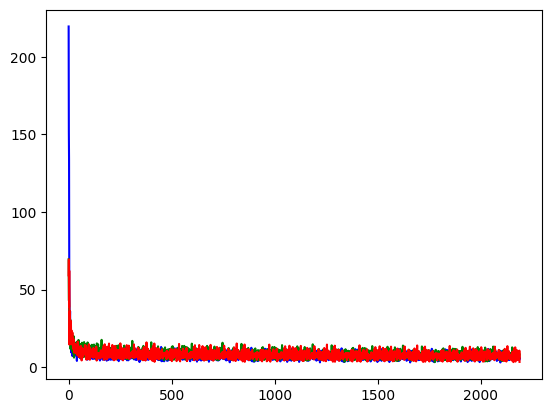

In [ ]:
plt.plot(training_loss[:,0], color = 'blue')
plt.plot(training_loss[:,1], color = 'green')
plt.plot(training_loss[:,2], color = 'red')

In [ ]:
# # production
# example_x = np.expand_dims(test_df.iloc[0,:-3].to_numpy(), axis = 1) # shape = (10,1)
# predicted_y = model.forward(example_x)
# predicted_y

In [ ]:
# testing
test_x = test_df[:, :-3].T # shape = (10, n)
test_y = test_df[:, -3:].T # shape = (3, n)

test_pred = model.forward(test_x)

In [ ]:
print(test_y.shape, test_pred.shape)

(3, 1400) (3, 1400)


In [ ]:
# pearson correlation
r1_ = np.corrcoef(test_y[0,:].squeeze(), test_pred[0,:].squeeze())
r2_ = np.corrcoef(test_y[1,:].squeeze(), test_pred[1,:].squeeze())
r3_ = np.corrcoef(test_y[2,:].squeeze(), test_pred[2,:].squeeze())

In [ ]:
r1_

array([[1.        , 0.97589222],
       [0.97589222, 1.        ]])

In [ ]:
r2_

array([[1.        , 0.92151856],
       [0.92151856, 1.        ]])

In [ ]:
r3_

array([[1.        , 0.90288579],
       [0.90288579, 1.        ]])

In [ ]:
# mean squared error

loss = get_loss(test_pred, test_y) # loss = mean square error
loss

array([6.92151002, 7.33982264, 7.21890073])

In [ ]:
# mean absolute error
loss = get_loss_mae(test_pred, test_y) # loss = mean absolute error
loss


array([2.08841409, 2.16792737, 2.13257788])

In [ ]:
correlation_check_model1 = Linear(ip_nodes = 1, op_nodes = 1, initialisation = 'constant')

correlation_losses1 = correlation_check_model1.fit(generator = get_minibatch, batch_size = batch_size, x = test_y[0:1,:], y = test_pred[0:1,:], lr = 1.1*1e-9)
correlation_losses1 = np.array(correlation_losses1)

In [ ]:
correlation_check_model2 = Linear(ip_nodes = 1, op_nodes = 1, initialisation = 'constant')

correlation_losses2 = correlation_check_model2.fit(generator = get_minibatch, batch_size = batch_size, x = test_y[1:2,:], y = test_pred[1:2,:],n_epochs = 10, lr = 1.1*1e-9)
correlation_losses2 = np.array(correlation_losses2)

In [ ]:
correlation_check_model3 = Linear(ip_nodes = 1, op_nodes = 1, initialisation = 'constant')

correlation_losses3 = correlation_check_model3.fit(generator = get_minibatch, batch_size = batch_size, x = test_y[2:,:], y = test_pred[2:,:],n_epochs = 10, lr = 1.1*1e-9)
correlation_losses3 = np.array(correlation_losses3)

In [ ]:
plt.plot(correlation_losses1[:,0], color = 'blue')
plt.plot(correlation_losses2[:,0], color = 'green')
plt.plot(correlation_losses3[:,0], color = 'red')

In [ ]:
print(correlation_check_model1.weights, correlation_check_model2.weights, correlation_check_model3.weights)

[[0.99973401]] [[0.99974642]] [[0.99975867]]


In [ ]:
# correlation plots

ig1, axs = plt.subplots(2, 2, figsize=(20, 10), dpi = 100)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
# plt.subplots_adjust(vspace=0.2)

axs[0][0].set_xlabel("Y-axis")
axs[0][0].set_ylabel("X-axis")
axs[0][0].title.set_text(f"coordinate 1")
axs[0][0].scatter(x = test_y[0,:], y = test_pred[0,:])
axs[0][0].plot(np.linspace(np.min(test_y[0,:]), np.max(test_y[0,:]), 20), np.linspace(np.min(test_y[0,:]), np.max(test_y[0,:]), 20))
axs[0][0].plot(np.linspace(np.min(test_y[0,:]), np.max(test_y[0,:]), 20), correlation_check_model1.weights[0,0]*np.linspace(np.min(test_y[0,:]), np.max(test_y[0,:]), 20), color = 'yellow')

axs[0][1].set_xlabel("Y-axis")
axs[0][1].set_ylabel("X-axis")
axs[0][1].title.set_text(f"coordinate 2")
axs[0][1].scatter(x = test_y[1,:], y = test_pred[1,:])
axs[0][1].plot(np.linspace(np.min(test_y[1,:]), np.max(test_y[1,:]), 20), np.linspace(np.min(test_y[1,:]), np.max(test_y[1,:]), 20))
axs[0][1].plot(np.linspace(np.min(test_y[1,:]), np.max(test_y[1,:]), 20), correlation_check_model2.weights[0,0]*np.linspace(np.min(test_y[1,:]), np.max(test_y[1,:]), 20), color = 'green')

axs[1][0].set_xlabel("Y-axis")
axs[1][0].set_ylabel("X-axis")
axs[1][0].title.set_text(f"coordinate 3")
axs[1][0].scatter(x = test_y[2,:], y = test_pred[2,:])
axs[1][0].plot(np.linspace(np.min(test_y[2,:]), np.max(test_y[2,:]), 20), np.linspace(np.min(test_y[2,:]), np.max(test_y[2,:]), 20))
axs[1,0].plot(np.linspace(np.min(test_y[1,:]), np.max(test_y[1,:]), 20), correlation_check_model3.weights[0,0]*np.linspace(np.min(test_y[1,:]), np.max(test_y[1,:]), 20), color = 'red')

the outputs are:<br>
correlation_losses<br>
<img src="https://drive.google.com/uc?id=1kJdBkmfVqRr7iXQyJSBoIPhOjpaRMJFS" width=200 height=200>

correlation_graphs<br>
<img src="https://drive.google.com/uc?id=1EC2_X_ydXInHTUr9Y5vmzmAlVTcyx95u" width=400 height=400>



**Question 2**<br>
Generalised Regression with polynomial kernel - Now, it turns out that the position onlydepends on the magnitude of the force  along 2 basis vectors (features  1 and 2).  That is,  therecordings in Q1 are derived quantities from these two independent features and share a poly-nomial relationship.  Hence, use a polynomial kernel to predict the position of the particle giventhe 2 features.<br>
Implement a generalised regression with a polynomial kernel with 3 targets.

In [ ]:
def weights(fi,target):
        L=0.01
        reg=L* np.eye(25)
        W=np.zeros((25,3))
        W=np.linalg.pinv(fi.T @fi + reg ) @ fi.T @ target
        return W

def kernel(x1,x2):
    monomials=[]
    monomials.append(x1**(i)* x2**(j))
    monomials=np.array(monomials)
    return monomials


def read_txt_file(file_path):
    data = np.loadtxt(file_path, delimiter='\t', skiprows=1)
    np.random.shuffle(data)
    return data  # Return the NumPy array representation directly

file_path = "C:/Users/nilad/Downloads/PRNN asgmt1/binary_classification/binary_classification_data_group_42_train.txt"
matrix = np.loadtxt(file_path, skiprows=1)
matrix= matrix.astype(float)
# matrix=matrix[1:]
N=matrix.shape[0]
min_val = np.min(matrix)
max_val = np.max(matrix)
matrix = (matrix - min_val) / (max_val - min_val)
feat=matrix[:,0:2]
target=matrix[:,2:5]
W=np.zeros((25,3))
phi=np.zeros((N,25))
for i in range(N):
    x1=feat[i,0]
    x2=feat[i,1]
    phi[i,:]=kernel(x1,x2)

W=weights(phi,target)
pred= phi @ W

Error_matrix = pred - target
sqerr=Error_matrix**2

pearson1 = np.corrcoef(target[0].squeeze(), pred[0].squeeze())[0, 1]
pearson2 = np.corrcoef(target[1].squeeze(), pred[1].squeeze())[0, 1]
pearson3 = np.corrcoef(target[2].squeeze(), pred[2].squeeze())[0, 1]
print("the pearson coeffecients for y1,y2,y3 are : ",[pearson1,pearson2,pearson3])
print("the rms error for y1,y2,y3 are :",np.sqrt(np.sum(sqerr[:,0]))/N,np.sqrt(np.sum(sqerr[:,1]))/N,np.sqrt(np.sum(sqerr[:,2]))/N)
print("the absolute error for y1,y2,y3 are :",np.sum(np.abs(Error_matrix[0]))/N,np.sum(np.abs(Error_matrix[1]))/N,np.sum(np.abs(Error_matrix[2]))/N)
print("the mean squared error for y1,y2,y3 are :",np.sum(sqerr[:,0])/N,np.sum(sqerr[:,1])/N,np.sum(sqerr[:,2])/N)

x_values = target[:,0]  # Example x-axis values
y_values = pred[:,0] # Example y-axis values
# Plot the x_values vs y_values
plt.plot(x_values, y_values, 'o')

# Set labels for the axes
plt.xlabel('true Y1')
plt.ylabel('pred Y1')

# Set title for the
plt.title('Plot of predY1 vs True Y1')
plt.grid(True)
plt.show()

x_values = target[:,1]  # Example x-axis values
y_values = pred[:,1] # Example y-axis values
# Plot the x_values vs y_values
plt.plot(x_values, y_values, 'o')

# Set labels for the axes
plt.xlabel('True Y2')
plt.ylabel('pred Y2')

# Set title for the
plt.title('Plot of predY2 vs True Y2')
plt.grid(True)
plt.show()

x_values = target[:,2]  # Example x-axis values
y_values = pred[:,2] # Example y-axis values
# Plot the x_values vs y_values
plt.plot(x_values, y_values, 'o')

# Set labels for the axes
plt.xlabel('true Y3')
plt.ylabel('pred Y3')

# Set title for the
plt.title('Plot of predY3 vs TrueY3')
plt.grid(True)
plt.show()

The outputs are:<br>
<img src="https://drive.google.com/uc?id=1HC-H2fD_k5js-ZEwWAtLnqRDEAffM2Kc" >

<img src="https://drive.google.com/uc?id=1IKK3yPXq0o0fmuFHUBZ8LV4KXPwnnK6Z" width=300 height=300>

<img src="https://drive.google.com/uc?id=1RQry4ufoE5ajH5K6PfSmN39rBpyzpZ6P" width=300 height=300>

<img src="https://drive.google.com/uc?id=1nC_18lydlJUWl72e1wYmDHgmIPPlD3Ds" width=300 height=300>


**Question 3**
Generalised Regression with non-polynomial kernel - The probability of rain on a particularday depends non-linearly on 5 satellite readings.  You need to figure out the generalised regressionfunction that predicts the probability of rain given these features.<br>
Implement a generalised regression with a non-polynomial kernel with 1 target.

In [ ]:
file_path = '/content/drive/My Drive/prnn_q1_c.txt'
data = np.loadtxt(file_path, delimiter='\t', skiprows=1)
np.random.shuffle(data)
Y=data[:,5].reshape((-1,1))
X=data[:,:5]
mean = np.mean(X, axis=0)
std_dev = np.std(X, axis=0)
X = (X - mean) / std_dev
one = np.ones((X.shape[0], 1))
X = np.hstack((X, one))
diff=int((X.shape[0])*0.8)
Xtrain=X[:diff,:]
Xtest=X[diff:,:]
Ytrain=Y[:diff]
Ytest=Y[diff:]

In [ ]:
#Implementation of logistic regression to compare results

def sigm(w,x):
  t = x@w.T
  return 1 / (1 + np.exp(-t, dtype=np.float64))


def train(X,Y,loss="mse",bs=32,lr=0.001,reg=0):
  #w=1x6 ,xi=1x6=>x=batch_sizex6
  w=np.zeros(X[0].reshape((1,-1)).shape, dtype=np.float64)
  #a,b=X[0].reshape((1,-1)).shape
  #w=np.random.rand(a,b)
  total=X.shape[0]
  for i in range(0, total, bs):
    x=X[i:i+bs,:]
    y=Y[i:i+bs]
    pred=sigm(w,x)
    if loss=="mse":
      temp=np.multiply(pred-y,pred)
      der=np.multiply(1-pred,temp)
      los=der.T@x/bs
      w=w+reg*w-lr*los
    if loss=="abs":
      temp=np.multiply(np.sign(pred-y),pred)
      der=np.multiply(1-pred,temp)
      los=der.T@x/bs
      w=w+reg*w-lr*los
  return w

def absLoss(pred,Y):
  return np.abs(Y-pred)

def mseLoss(pred,Y):
  return np.square(Y-pred)

def eval(x,y,w,loss,losstype):
  count=0
  pred=sigm(w,x)
  los=loss(pred,y)
  pearson = np.corrcoef(y.squeeze(), pred.squeeze())[0, 1]
  print("the pearson coeffecient is : ",pearson)
  print(f"the mean error with {losstype}-Loss metric is : ",(np.sum(los)/y.shape[0]))
  if losstype=="mse":
    print("the mean error with rmse-Loss metric is : ",((np.sum(los,dtype=np.float64)/y.shape[0])**0.5))
  for i in range(y.shape[0]):
    if abs(pred[i]-y[i])<=0.1:
      count+=1
  print("count of points predicted within a range of 0.1 error is ",count)
  plt.figure(figsize=(4, 4))
  plt.scatter(y, pred, color='blue', alpha=0.5)
  plt.title('Y_Truth vs Y_Prediction : logistic regression')
  plt.xlabel('Y-Truth')
  plt.ylabel('Y-Prediction')
  plt.grid(True)
  plt.show()

the pearson coeffecient is :  0.9635653749041321
the mean error with absolute-Loss metric is :  0.06483631524434612
count of points predicted within a range of 0.1 error is  1167


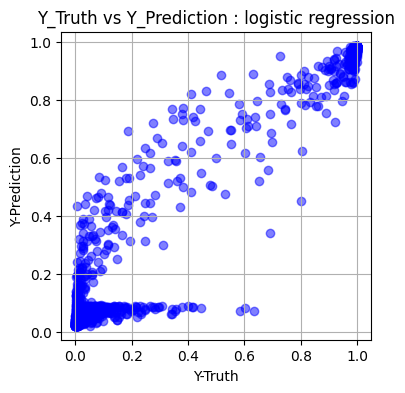

the pearson coeffecient is :  0.9678262172342362
the mean error with mse-Loss metric is :  0.00933477665398505
the mean error with rmse-Loss metric is :  0.0966166479132093
count of points predicted within a range of 0.1 error is  1203


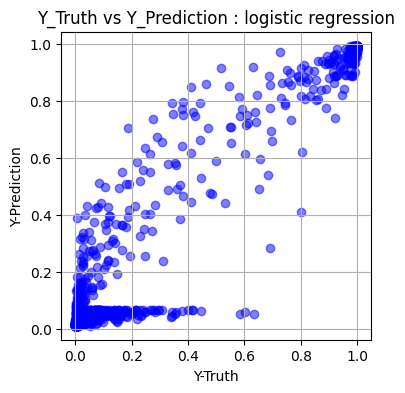

In [ ]:
w1=train(Xtrain,Ytrain,"abs",bs=64,lr=0.1,reg=0.01)
w2=train(Xtrain,Ytrain,"mse",bs=32,lr=0.1,reg=0.01)

eval(Xtest,Ytest,w1,absLoss,"absolute")
eval(Xtest,Ytest,w2,mseLoss,"mse")

In [ ]:
#non-linear kernels
def learn(x,y,l=0):
  w=np.linalg.pinv(x.T@x+l*np.identity(x.shape[1]))@x.T@y
  return w

def conv(x,typ="sigm",s=1):
  if typ=="sigm":
    y=1+np.exp(-x/s)
    x=1/y
  if typ=="cos":
    x=np.cos(x/s)
  if typ=="tanh":
    x=np.tanh(x/s)
  return x

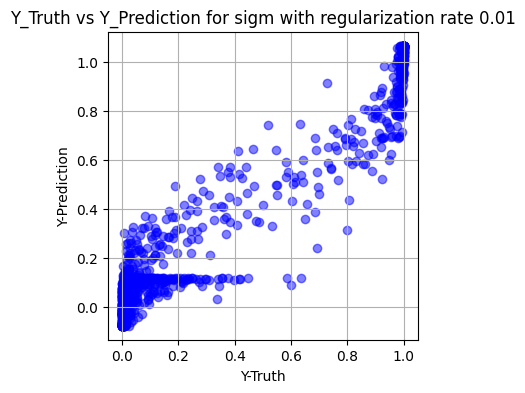

count of points predicted within a range of 0.1 error is  1158
the pearson coeffecient is :  0.9668467017061289
the mean error with rmse-Loss metric is :  0.00254459685350398
the mean error with mse-Loss metric is :  0.009064962405607295
the mean error with abs-Loss metric is :  0.0693489284505219


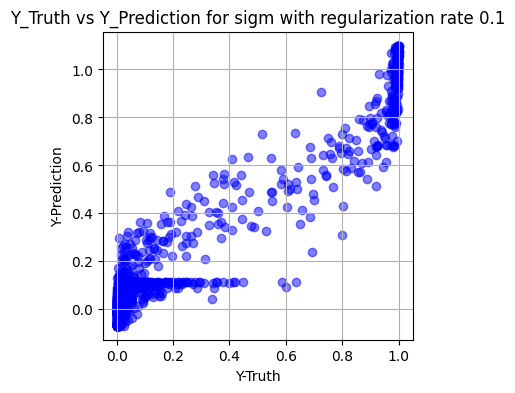

count of points predicted within a range of 0.1 error is  1151
the pearson coeffecient is :  0.9661750240051455
the mean error with rmse-Loss metric is :  0.0025698863949890315
the mean error with mse-Loss metric is :  0.009246042516409609
the mean error with abs-Loss metric is :  0.06856184455327999


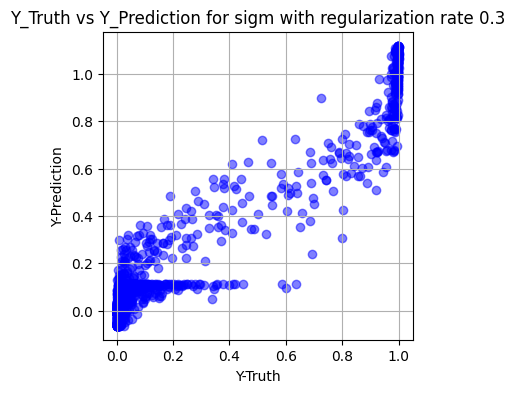

count of points predicted within a range of 0.1 error is  1122
the pearson coeffecient is :  0.9654292484626672
the mean error with rmse-Loss metric is :  0.0025976347804344195
the mean error with mse-Loss metric is :  0.009446789033531603
the mean error with abs-Loss metric is :  0.0682913407418199


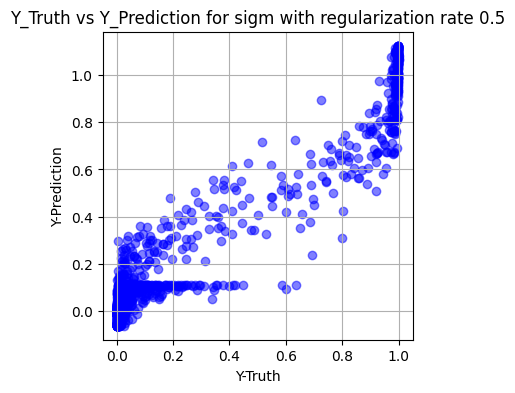

count of points predicted within a range of 0.1 error is  1118
the pearson coeffecient is :  0.9651259513537229
the mean error with rmse-Loss metric is :  0.0026088473035095422
the mean error with mse-Loss metric is :  0.009528517954240616
the mean error with abs-Loss metric is :  0.06822632007994452


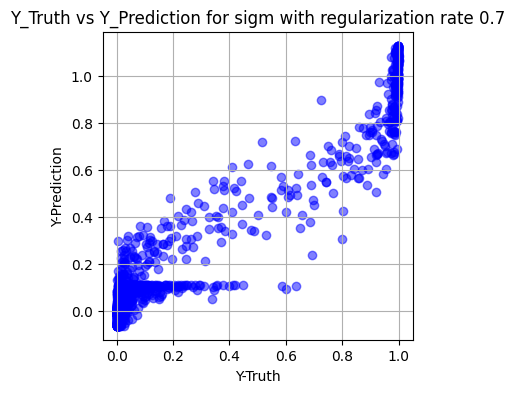

count of points predicted within a range of 0.1 error is  1116
the pearson coeffecient is :  0.9649665570454363
the mean error with rmse-Loss metric is :  0.002614739355049954
the mean error with mse-Loss metric is :  0.00957160665278587
the mean error with abs-Loss metric is :  0.06818927904044811


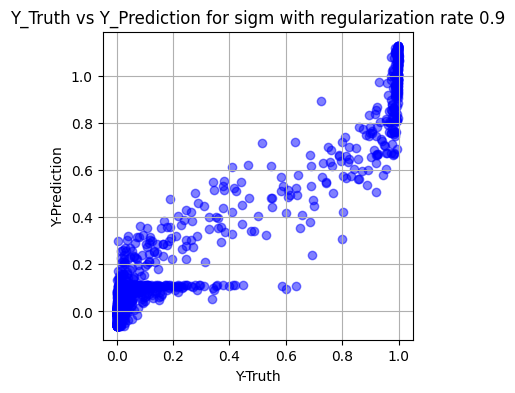

count of points predicted within a range of 0.1 error is  1115
the pearson coeffecient is :  0.9648699946431168
the mean error with rmse-Loss metric is :  0.0026183253733269626
the mean error with mse-Loss metric is :  0.009597878864850891
the mean error with abs-Loss metric is :  0.0681616366451145


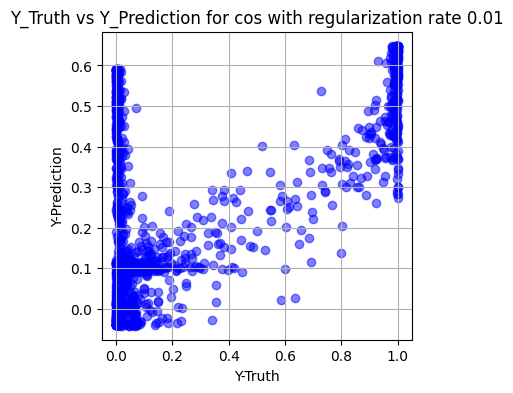

count of points predicted within a range of 0.1 error is  650
the pearson coeffecient is :  0.6044527758873808
the mean error with rmse-Loss metric is :  0.007947617052581934
the mean error with mse-Loss metric is :  0.08843046354028762
the mean error with abs-Loss metric is :  0.2200415107614174


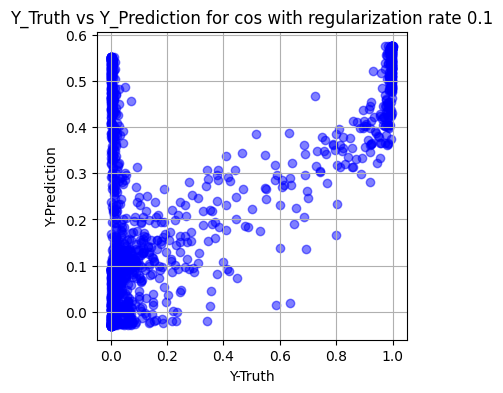

count of points predicted within a range of 0.1 error is  688
the pearson coeffecient is :  0.5897374754725753
the mean error with rmse-Loss metric is :  0.008064240666828176
the mean error with mse-Loss metric is :  0.09104476854553549
the mean error with abs-Loss metric is :  0.22359798881405876


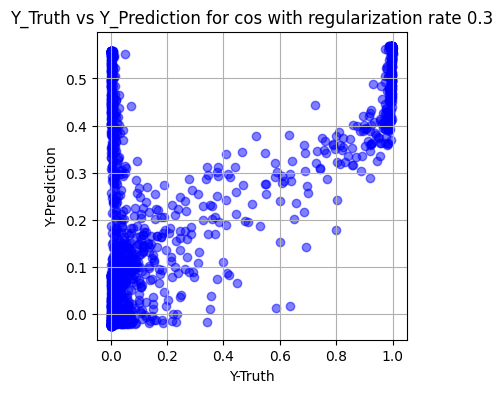

count of points predicted within a range of 0.1 error is  675
the pearson coeffecient is :  0.577079449548126
the mean error with rmse-Loss metric is :  0.008151237832427124
the mean error with mse-Loss metric is :  0.09301974948110774
the mean error with abs-Loss metric is :  0.22479559198279608


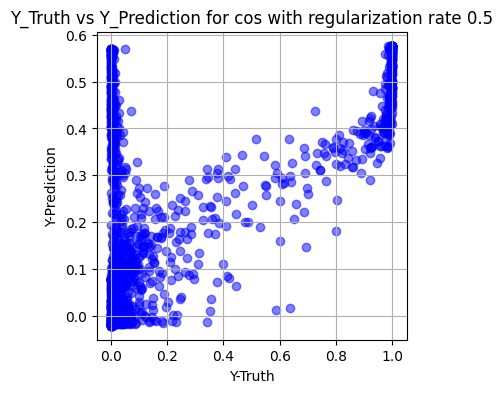

count of points predicted within a range of 0.1 error is  674
the pearson coeffecient is :  0.5729480107036387
the mean error with rmse-Loss metric is :  0.008178878038036413
the mean error with mse-Loss metric is :  0.09365166434550413
the mean error with abs-Loss metric is :  0.22496765046216102


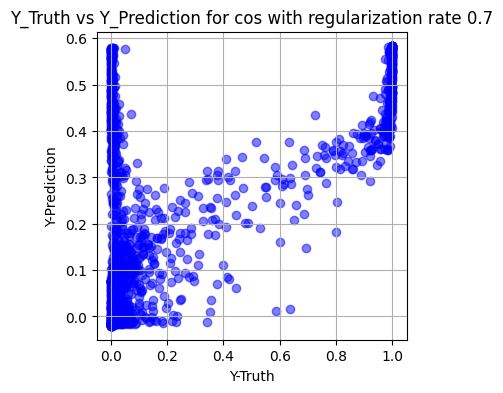

count of points predicted within a range of 0.1 error is  675
the pearson coeffecient is :  0.5709121164998651
the mean error with rmse-Loss metric is :  0.008192440865627884
the mean error with mse-Loss metric is :  0.09396252227153366
the mean error with abs-Loss metric is :  0.2249717009333165


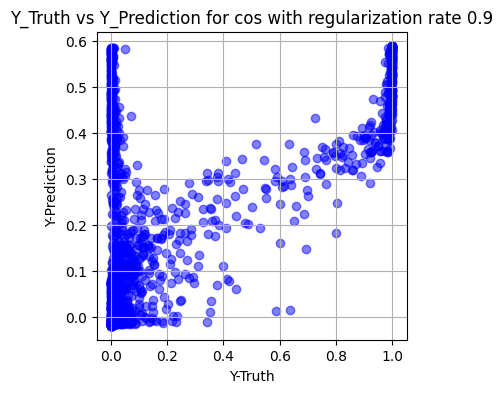

count of points predicted within a range of 0.1 error is  672
the pearson coeffecient is :  0.5696977449910237
the mean error with rmse-Loss metric is :  0.00820053510589757
the mean error with mse-Loss metric is :  0.09414828643228189
the mean error with abs-Loss metric is :  0.2249350867039611


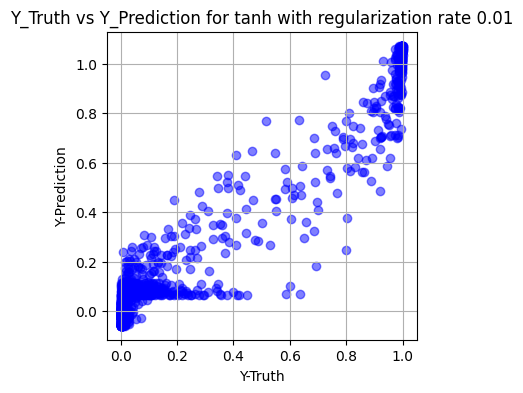

count of points predicted within a range of 0.1 error is  1203
the pearson coeffecient is :  0.970154454201005
the mean error with rmse-Loss metric is :  0.002416744400472681
the mean error with mse-Loss metric is :  0.008176914896102479
the mean error with abs-Loss metric is :  0.062010813833563806


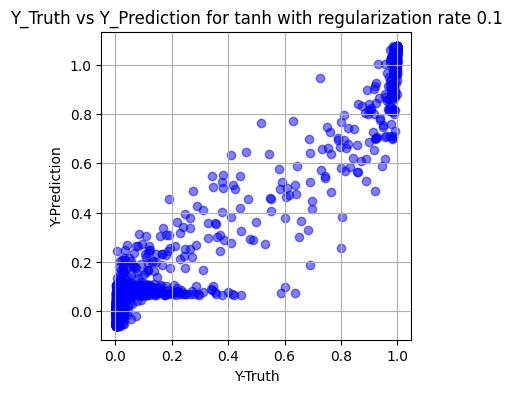

count of points predicted within a range of 0.1 error is  1208
the pearson coeffecient is :  0.9701527845008062
the mean error with rmse-Loss metric is :  0.0024167612245600436
the mean error with mse-Loss metric is :  0.008177028743151744
the mean error with abs-Loss metric is :  0.06194304105838252


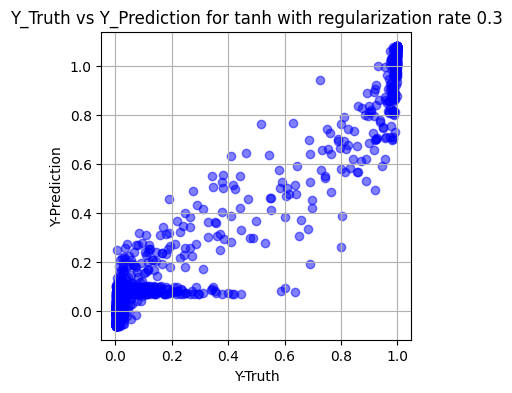

count of points predicted within a range of 0.1 error is  1203
the pearson coeffecient is :  0.9700606494602131
the mean error with rmse-Loss metric is :  0.0024203943541814075
the mean error with mse-Loss metric is :  0.008201632361654528
the mean error with abs-Loss metric is :  0.061989436963645374


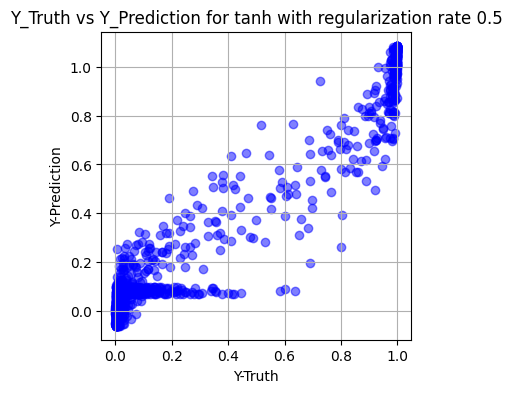

count of points predicted within a range of 0.1 error is  1200
the pearson coeffecient is :  0.9699888633663771
the mean error with rmse-Loss metric is :  0.002423239655907619
the mean error with mse-Loss metric is :  0.008220926601948586
the mean error with abs-Loss metric is :  0.0620531695746892


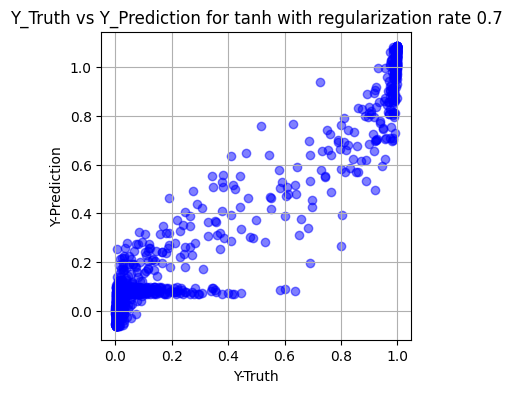

count of points predicted within a range of 0.1 error is  1199
the pearson coeffecient is :  0.9699396474106967
the mean error with rmse-Loss metric is :  0.0024251935543807947
the mean error with mse-Loss metric is :  0.008234189286694215
the mean error with abs-Loss metric is :  0.06210041547624992


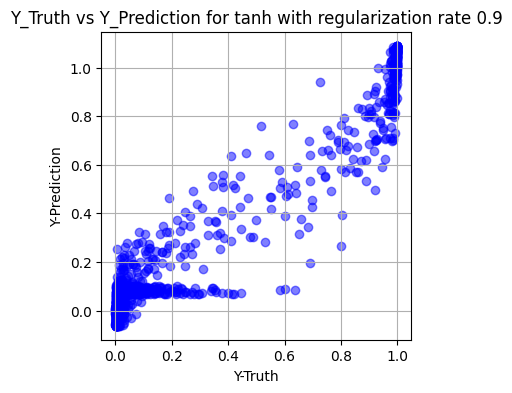

count of points predicted within a range of 0.1 error is  1200
the pearson coeffecient is :  0.9699047645595141
the mean error with rmse-Loss metric is :  0.0024265806984163888
the mean error with mse-Loss metric is :  0.008243611440297758
the mean error with abs-Loss metric is :  0.062132276172594855


In [ ]:
tipe=["sigm","cos","tanh"]
regl=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
for i in tipe:
  Xlearn=conv(Xtrain,i)#diff,5
  Xdo=conv(Xtest,i)
  for r in regl:
    w=learn(Xlearn,Ytrain,r)#5,1
    predict=Xdo@w#train,1
    count=0
    plt.figure(figsize=(4, 4))
    plt.scatter(Ytest, predict, color='blue', alpha=0.5)
    plt.title(f'Y_Truth vs Y_Prediction for {i} with regularization rate {r}')
    plt.xlabel('Y-Truth')
    plt.ylabel('Y-Prediction')
    plt.grid(True)
    plt.show()
    for j in range(Ytest.shape[0]):
      if abs(predict[j]-Ytest[j])<=0.1:
        count+=1
    print("count of points predicted within a range of 0.1 error is ",count)
    pearson = np.corrcoef(Ytest.squeeze(), predict.squeeze())[0, 1]
    print("the pearson coeffecient is : ",pearson)
    error=predict-Ytest
    print(f"the mean error with rmse-Loss metric is : ",(np.sum(np.square(error))**0.5/error.shape[0]))
    print(f"the mean error with mse-Loss metric is : ",((np.sum(np.square(error))/error.shape[0])))
    print(f"the mean error with abs-Loss metric is : ",(np.sum(np.abs(error))/error.shape[0]))

**Question 4** Binary Classification :  The data from 10 sensors planted at an industrial cite is tabulated.And depending on these sensor value we take a decision on the kind of product(one of 2 products).The task is to predict the product being produced by looking at the observation from these 10sensors.  Implement on all the relevant methods given below and for each of the method use allthe relevant evaluation metrics<br>
Bayes’  classifiers  with  0-1  loss  assuming  Normal, GMMs  (with  diagonal  co-variances) as class-conditional densities.<br>
Bayes’ classifiers with non-parametric density estimators (parzen window) with 2 different ker-nels<br>
K-nearest neighbour classifiers with different K-values and 2 different distance metrics (Euclideanand Cosine-distances)

**Gaussian/Normal Priors**

In [ ]:
file_path = "C:/Users/nilad/Downloads/PRNN asgmt1/binary_classification/binary_classification_data_group_42_train.txt"
matrix = np.loadtxt(file_path, skiprows=1)
matrix= matrix.astype(float)
ratio=0.8
N=matrix.shape[0]
r=int(ratio*N)
train=matrix[0:r,:]
test=matrix[r:N,:]
train_feature=train[:,0:10]
train_label=train[:,10:11]
test_feature=test[:,0:10]
test_label=test[:,10:11]

mean1=np.zeros(10)
mean0=np.zeros(10)
cov0=np.zeros((10,10))
cov1=np.zeros((10,10))
count0=count1=0
for i in range(r):
    if train_label[i,0]==0:
        count0+=1
        mean0+=train_feature[i,:]
    else:
        count1+=1
        mean1+=train_feature[i,:]

prior0=count0/r
prior1=count1/r
# print(prior0,prior1)
mean0/=count0
mean1/=count1
plot0=[]
plot1=[]
for i in range(r):
    if train_label[i,0]==0:
        x0=train_feature[i,:]
        cov0+=np.outer(x0-mean0,x0-mean0)
    else:
        x1=train_feature[i,:]
        cov1+=np.outer(x1-mean1,x1-mean1)
cov0/=count0
cov1/=count1
cov=cov1*prior1 + cov0*prior0
# print(count1,count0)
def multivariate_gaussian(x, mean, cov):
    k = len(mean)
    exponent = -0.5 * np.dot(np.dot((x - mean).T, np.linalg.pinv(cov)), (x - mean))
    coefficient = 1 / np.sqrt((2 * np.pi) ** k * np.linalg.det(cov))
    return coefficient * np.exp(exponent)

err1=0
err2=0
conf1=np.zeros((2,2))
conf2=np.zeros((2,2))
def F1(conf):
    precision=conf[0,0]/np.sum(conf,axis=1)[0]
    recall=conf[0,0]/np.sum(conf,axis=0)[0]
    F1score=2*precision*recall/(precision+recall)
    return F1score
for i in range(N-r):
    posterior0=prior0*multivariate_gaussian(test_feature[i,:],mean0,cov0)
    posterior1=prior1*multivariate_gaussian(test_feature[i,:],mean1,cov1)
    # print(posterior0,posterior1)
    if posterior0>posterior1:
        pred=0
    else:
        pred=1
    # print(pred,test_label[i,0])
    if pred!=test_label[i,0]:
        err1+=1
        if pred==0:
            conf1[0,1]+=1
        else:
            conf1[1,0]+=1
    else:
        if pred==1:
            conf1[0,0]+=1
        else:
            conf1[1,1]+=1
print("With different covariances:")
print("Error:",err1/(N-r))
print("Confusion matrix:\n",conf1)
print("F1 score:",F1(conf1),"\n\n")

err2=0
for i in range(N-r):
    posterior0=prior0*multivariate_gaussian(test_feature[i,:],mean0,cov)
    posterior1=prior1*multivariate_gaussian(test_feature[i,:],mean1,cov)
    #print(posterior0,posterior1)
    if posterior0>posterior1:
        pred=0
    else:
        pred=1
    # print(pred,test_label[i,0])
    if pred!=test_label[i,0]:
        err2+=1
        if pred==0:
            conf2[0,1]+=1
        else:
            conf2[1,0]+=1
    else:
        if pred==1:
            conf2[0,0]+=1
        else:
            conf2[1,1]+=1
print("With same covariances(Linear Classifier):")
print("Error:",err2/(N-r))
print("Confusion matrix:\n",conf2)
print("F1 score:",F1(conf2))

The outputs are:<br>
<img src="https://drive.google.com/uc?id=1cVboAmOjsVSxRvgVyZtnDun4HxcX50C4">


**GMM**

In [ ]:
file_path = "C:/Users/nilad/Downloads/PRNN asgmt1/binary_classification/binary_classification_data_group_42_train.txt"
matrix = np.loadtxt(file_path, skiprows=1)
matrix= matrix.astype(float)
ratio=0.8
N=matrix.shape[0]
r=int(ratio*N)
train=matrix[0:r,:]
test=matrix[r:N,:]
train_feature=train[:,0:10]
train_label=train[:,10:11]
test_feature=test[:,0:10]
test_label=test[:,10:11]
K=5
def multivariate_gaussian(x, mean, cov):
    k = len(mean)
    exponent = -0.5*np.dot(np.dot((x-mean).T, np.linalg.pinv(cov)), (x - mean))
    coefficient = 1 / np.sqrt((2 * np.pi) ** k * np.linalg.det(cov))
    return coefficient * np.exp(exponent)

def EM1(x,K):
    n=x.shape[0]
    # pi = np.random.rand(K)
    # pi /= np.sum(pi)
    gamma=np.zeros((n,K))
    pi=np.ones(K)/K
    # pi=[0.1,0.25,0.15,0.05,0.10,0.15,0.1,0,0.05,0.05,0]
    mu= np.zeros((10,K))
    cov=np.zeros((10,10,K))
    l=[]
    for i in range(K):
          cov[:, :, i] = np.eye(10)

    for iter in range(5):
        sum=np.zeros(n)
        for i in range(n):
            for t in range(K):
                sum[i]+=multivariate_gaussian(x[i,:],mu[:,t],cov[:,:,t])*pi[t]
            for j in range(K):
                gamma[i,j]=multivariate_gaussian(x[i,:],mu[:,j],cov[:,:,j])*pi[j]/(sum[i])

        for i in range(K):
            for j in range(n):
                mu[:,i]=mu[:,i]+(gamma[j,i]*x[j,:])
            mu[:,i]/=np.sum(gamma[:,i],axis=0)

        for i in range(K):
            inter=np.zeros(10)
            for j in range(n):
                cov[:,:,i]+=gamma[j,i]*(np.outer((x[j,:]-mu[:,i]), (x[j,:]-mu[:,i])))
            cov[:,:,i]/=np.sum(gamma[:,i],axis=0)



        for i in range(K):
            pi[i]=np.sum(gamma[:,i],axis=0)/n
        likelihood=np.sum(np.log(sum))
        l.append(np.exp(likelihood))
        # print(likelihood,iter)
    l=np.array(l)
    return mu,cov,pi,l


def EM2(x,K):
    n=x.shape[0]
    # pi = np.random.rand(K)
    # pi /= np.sum(pi)
    gamma=np.zeros((n,K))
    pi=np.ones(K)/K
    # pi=[0.1,0.25,0.15,0.05,0.10,0.15,0.1,0,0.05,0.05,0]
    mu= np.zeros((10,K))
    cov=np.zeros((10,10,K))
    l=[]
    for i in range(K):
          cov[:, :, i] = np.eye(10)
    for iter in range(5):
        sum=np.zeros(n)
        for i in range(n):
            for t in range(K):
                sum[i]+=multivariate_gaussian(x[i,:],mu[:,t],cov[:,:,t])*pi[t]
            for j in range(K):
                gamma[i,j]=multivariate_gaussian(x[i,:],mu[:,j],cov[:,:,j])*pi[j]/(sum[i])

        for i in range(K):
            for j in range(n):
                mu[:,i]=mu[:,i]+(gamma[j,i]*x[j,:])
            mu[:,i]/=np.sum(gamma[:,i],axis=0)

        for i in range(K):
            inter=np.zeros(10)
            for j in range(n):
              # print(x[j,:], mu[:,i])
              for d in range(10):

                inter[d]+=gamma[j,i]*((x[j,d]-mu[d,i]))**2
            cov[:,:,i]=np.diag(inter)
            cov[:,:,i]/=np.sum(gamma[:,i],axis=0)
        for i in range(K):
            pi[i]=np.sum(gamma[:,i],axis=0)/n
        likelihood=np.sum(np.log(sum))
        l.append(np.exp(likelihood))
        # print(likelihood,iter)
    l=np.array(l)
    return mu,cov,pi,l

class0=[]
class1=[]
count0=0
count1=0
for i in range(r):
    if train_label[i,:]==0:
        class0.append(train_feature[i,:])
        count0+=1
    else:
        class1.append(train_feature[i,:])
        count1+=1
prior0=count0/r
prior1=count1/r
class0=np.array(class0,dtype=float)
class1=np.array(class1,dtype=float)
# print(class1.shape)

# print(mu0,cov0,pi0)

def mixture(x,mean,cov,pi,K):
    sum=0
    for i in range(K):
        sum+=multivariate_gaussian(x,mean[:,i],cov[:,:,i])*pi[i]
    return sum
err1_vals=[]
err2_vals=[]
K_vals=[]
F1_vals1=[]
F1_vals2=[]
conf1=np.zeros((2,2,10))
conf2=np.zeros((2,2,10))
def F1(conf):
    precision=conf[0,0]/np.sum(conf,axis=1)[0]
    recall=conf[0,0]/np.sum(conf,axis=0)[0]
    F1score=2*precision*recall/(precision+recall)
    return F1score
list1=[]
list2=[]
for K in range(2,8):
    mu0_1,cov0_1,pi0_1,l1=EM1(class0,K)
    mu1_1,cov1_1,pi1_1,l2=EM1(class1,K)
    mu0_2,cov0_2,pi0_2,l3=EM2(class0,K)
    mu1_2,cov1_2,pi1_2,l4=EM2(class1,K)
    list1.append(l1)
    list2.append(l3)
    err1=0
    err2=2
    for i in range(N-r):

        posterior0=prior0*mixture(test_feature[i,:],mu0_1,cov0_1,pi0_1,K)
        posterior1=prior1*mixture(test_feature[i,:],mu1_1,cov1_1,pi1_1,K)
        #print(posterior0,posterior1)
        if posterior0>posterior1:
            pred=0
        else:
            pred=1
        # print(pred,test_label[i,0])
        # print(K,i)
        if pred!=test_label[i,0]:
          err1+=1
          if pred==0:
            conf1[0,1,K]+=1
          else:
            conf1[1,0,K]+=1
        else:
          if pred==1:
            conf1[0,0,K]+=1
          else:
            conf1[1,1,K]+=1


        posterior0=prior0*mixture(test_feature[i,:],mu0_2,cov0_2,pi0_2,K)
        posterior1=prior1*mixture(test_feature[i,:],mu1_2,cov1_2,pi1_2,K)
        #print(posterior0,posterior1)
        if posterior0>posterior1:
            pred=0
        else:
            pred=1
        # print(pred,test_label[i,0])
        # print(K,i)
        if pred!=test_label[i,0]:
          err2+=1
          if pred==0:
            conf2[0,1,K]+=1
          else:
            conf2[1,0,K]+=1
        else:
          if pred==1:
            conf2[0,0,K]+=1
          else:
            conf2[1,1,K]+=1
    print("Without independence assumption:")
    print("Error for K=",K, "is:",err1/(N-r))
    print("Confusion matrix:",conf1[:,:,K])
    print("F1 score:",F1(conf1[:,:,K]),"\n\n")
    print("With independence assumption:")
    print("Error for K=",K, "is:",err2/(N-r))
    print("Confusion matrix:",conf2[:,:,K])
    print("F1 score:",F1(conf2[:,:,K]))
    err1_vals.append(err1/(N-r))
    err2_vals.append(err2/(N-r))
    K_vals.append(K)
    F1_vals1.append(F1(conf1[:,:,K]))
    F1_vals2.append(F1(conf2[:,:,K]))


err1_vals=np.array(err1_vals)
err2_vals=np.array(err2_vals)
K_vals=np.array(K_vals)
F1_vals1=np.array(F1_vals1)
F1_vals2=np.array(F1_vals2)
# print(F1_vals,K_vals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(K_vals, err1_vals, label='Error (Without Independence)')
ax1.plot(K_vals, err2_vals, label='Error (With Independence)')
ax1.set_title('Errors vs. K values')
ax1.set_xlabel('K values')
ax1.set_ylabel('Error')
ax1.legend()
ax1.grid(True)
ax2.plot(K_vals, F1_vals1, label='F1 values (Without Independence)', color='red')
ax2.plot(K_vals, F1_vals2, label='F1 values (With Independence)', color='blue')
ax2.set_title('F1 Values vs. K values')
ax2.set_xlabel('K values')
ax2.set_ylabel('F1 Values')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()
plt.show()

the Outputs are:<br>
<img src="https://drive.google.com/uc?id=12_n5ixE1zguejJny4Xd9UD2j7EKVxUrv" width=400 height=200>

<img src="https://drive.google.com/uc?id=1o3YTcnCNV6LZQX-NCvuRx_guHgVCtb17" width=400 height=200>


**KNN and Parzen Window**

In [ ]:
file_path = "C:/Users/nilad/Downloads/PRNN asgmt1/binary_classification/binary_classification_data_group_42_train.txt"
matrix = np.loadtxt(file_path, skiprows=1)
matrix= matrix.astype(float)
ratio=0.95
N=matrix.shape[0]
r=int(ratio*N)
# print(r)
train=matrix[0:r,:]
test=matrix[r:N,:]
train_feature=train[:,0:10]
train_label=train[:,10:11]
test_feature=test[:,0:10]
test_label=test[:,10:11]

def find_euc_dist(x):
    euc_dist=np.zeros(r)
    for i in range(r):
        y=train_feature[i,:]
        euc_dist[i]=np.linalg.norm(y-x)

    return euc_dist
def find_cos_dist(x):
    cos_dist=np.zeros(r)
    for i in range(r):
        t=train_feature[i,:]
        # print(x.shape,t.shape)
        cos_dist[i]=1-(np.dot(x,t)/(np.linalg.norm(t)*np.linalg.norm(x)))
    return cos_dist

def KNN_euc(x,k):

    dist=find_euc_dist(x)
    combined = list(zip(dist, train_label))
    combined.sort(key=lambda x: x[0])
    k_smallest = combined[:k]
    k_smallest_dist = [item[0] for item in k_smallest]
    k_smallest_labels = [item[1] for item in k_smallest]
    if (np.sum(k_smallest_labels))>k/2:
        return 1
    else:
        return 0

def KNN_cos(x,k):

    dist=find_cos_dist(x)
    combined = list(zip(dist, train_label))
    combined.sort(key=lambda x: x[0])
    k_smallest = combined[:k]
    k_smallest_dist = [item[0] for item in k_smallest]
    k_smallest_labels = [item[1] for item in k_smallest]
    if (np.sum(k_smallest_labels))>k/2:
        return 1
    else:
        return 0

err1=0
err2=0
conf1=np.zeros((2,2,15))
conf2=np.zeros((2,2,15))
K_vals=[]
F1_vals1=[]
F1_vals2=[]
err1_vals=[]
err2_vals=[]
def F1(conf):
    # print(conf.shape)
    precision=conf[0,0]/np.sum(conf,axis=1)[0]
    recall=conf[0,0]/np.sum(conf,axis=0)[0]
    F1score=2*precision*recall/(precision+recall)
    return F1score
k=51
for iter in range(12):
    err1=0
    err2=0
    # print(iter)
    for i in range(N-r):
            z=test_feature[i,:]
            pred1=KNN_euc(z,k)
            pred2=KNN_cos(z,k)
                # print(pred,test_label[i,0])
            # print(i)
            if pred1!=test_label[i,0]:
                err1+=1
                if pred1==0:
                  conf1[0,1,iter]+=1
                else:
                  conf1[1,0,iter]+=1
            else:
                if pred1==1:
                  conf1[0,0,iter]+=1
                else:
                  conf1[1,1,iter]+=1

            if pred2!=test_label[i,0]:
                err2+=1
                if pred2==0:
                  conf2[0,1,iter]+=1
                else:
                  conf2[1,0,iter]+=1
            else:
                if pred2==1:
                  conf2[0,0,iter]+=1
                else:
                  conf2[1,1,iter]+=1

    K_vals.append(k)
    err1_vals.append(err1/(N-r))
    err2_vals.append(err2/(N-r))
    F1_vals1.append(F1(conf1[:,:,iter]))
    F1_vals2.append(F1(conf2[:,:,iter]))
    k+=10
    print("With Gaussian kernel:")
    print("Error for K=",k ,"is",err1/(N-r))
    print("Confusion matrix:",conf1[:,:,iter])
    print("F1 score:",F1(conf1[:,:,iter]),"\n\n")
    print("With Uniform kernel")
    print("Error for K=",k ,"is",err2/(N-r))
    print("Confusion matrix:",conf2[:,:,iter])
    print("F1 score:",F1(conf2[:,:,iter]))


err1_vals=np.array(err1_vals)
err2_vals=np.array(err2_vals)
F1_vals2=np.array(F1_vals2)
F1_vals1=np.array(F1_vals1)
K_vals=np.array(K_vals)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(K_vals, err1_vals, label='Error (Euclidean distance)')
ax1.plot(K_vals, err2_vals, label='Error (Cosine distance)')
ax1.set_title('Errors vs. K values')
ax1.set_xlabel('K values')
ax1.set_ylabel('Error')
ax1.legend()
ax1.grid(True)
ax2.plot(K_vals, F1_vals1, label='F1 scores (Euclidean distance)', color='red')
ax2.plot(K_vals, F1_vals2, label='F1 scores (Cosine distance)', color='blue')
ax2.set_title('F1 Values vs. K values')
ax2.set_xlabel('K values')
ax2.set_ylabel('F1 Scores')
ax2.legend()
ax2.grid(True)
plt.show()

file_path = "C:/Users/nilad/Downloads/PRNN asgmt1/binary_classification/binary_classification_data_group_42_train.txt"
matrix = np.loadtxt(file_path, skiprows=1)
matrix= matrix.astype(float)
ratio=0.95
N=matrix.shape[0]
r=int(ratio*N)
train=matrix[0:r,:]
test=matrix[r:N,:]
train_feature=train[:,0:10]
train_label=train[:,10:11]
test_feature=test[:,0:10]
test_label=test[:,10:11]

def normal_kernel(sample,x,h1):
    sum=0
    n=x.shape[0]
    h=h1/np.sqrt(n)
    V=h**10
    for i in range(1,n+1):

        y=(sample-x[i-1,:])/h
        exponent = -0.5*np.dot((y).T,y)
        coefficient = 1 / ((2 * np.pi) ** 5)
        sum+= coefficient*np.exp(exponent)*(1/(n*V))
    return sum

def unif_kernel(sample,x,h1):
    sum=0
    n=x.shape[0]
    h=h1/np.sqrt(n)
    V=h**10
    for i in range(n):
        y=(sample-x[i,:])/h
        if np.all((y>-0.5)&(y<0.5)):
            sum+=1/(n*V)
        else:
            sum+=0
    return sum

class0=[]
class1=[]
count0=0
count1=0
for i in range(r):
    if train_label[i,:]==0:
        class0.append(train_feature[i,:])
        count0+=1
    else:
        class1.append(train_feature[i,:])
        count1+=1
prior0=count0/r
prior1=count1/r
class0=np.array(class0,dtype=float)
class1=np.array(class1,dtype=float)

h1=0.1
err1_vals=[]
err2_vals=[]
F1_vals1=[]
F1_vals2=[]
h_vals=[]
conf1=np.zeros((2,2,40))
conf2=np.zeros((2,2,40))
def F1(conf):
    precision=conf[0,0]/np.sum(conf,axis=1)[0]
    recall=conf[0,0]/np.sum(conf,axis=0)[0]
    F1score=2*precision*recall/(precision+recall)
    return F1score
for iter in range(30):
    err1=0
    err2=0
    for i in range(N-r):

            posterior0=prior0*normal_kernel(test_feature[i,:],class0,h1)
            posterior1=prior1*normal_kernel(test_feature[i,:],class1,h1)
            p0=prior0*unif_kernel(test_feature[i,:],class0,h1)
            p1=prior1*unif_kernel(test_feature[i,:],class1,h1)
            #print(posterior0,posterior1)
            if posterior0>posterior1:
                pred=0
            else:
                pred=1

            if p0 > p1:
                pd=0
            else:
                pd=1
            # print(pred,test_label[i,0])
            # print(i)
            if pred!=test_label[i,0]:
                err1+=1
                if pred==0:
                  conf1[0,1,iter]+=1
                else:
                  conf1[1,0,iter]+=1
            else:
                if pred==1:
                  conf1[0,0,iter]+=1
                else:
                  conf1[1,1,iter]+=1



            # print(i)
            if pd!=test_label[i,0]:
                err2+=1
                if pd==0:
                  conf2[0,1,iter]+=1
                else:
                  conf2[1,0,iter]+=1
            else:
                if pd==1:
                  conf2[0,0,iter]+=1
                else:
                  conf2[1,1,iter]+=1

    h_vals.append(h1)
    err1_vals.append(err1/(N-r))
    err2_vals.append(err2/(N-r))
    F1_vals1.append(F1(conf1[:,:,iter]))
    F1_vals2.append(F1(conf2[:,:,iter]))
    h1+=4
    print("With Gaussian kernel:")
    print("Error for h1=",h1 ,"is",err1/(N-r))
    print("Confusion matrix:",conf1[:,:,iter])
    print("F1 score:",F1(conf1[:,:,iter]),"\n\n")
    print("With Uniform kernel")
    print("Error for h1=",h1 ,"is",err2/(N-r))
    print("Confusion matrix:",conf2[:,:,iter])
    print("F1 score:",F1(conf2[:,:,iter]))




err1_vals=np.array(err1_vals)
err2_vals=np.array(err2_vals)
F1_vals2=np.array(F1_vals2)
F1_vals1=np.array(F1_vals1)
h_vals=np.array(h_vals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(h_vals, err1_vals, label='Error 1')
ax1.plot(h_vals, err2_vals, label='Error 2')
ax1.set_title('Errors vs. h values')
ax1.set_xlabel('h values')
ax1.set_ylabel('Error')
ax1.legend()
ax1.grid(True)
ax2.plot(h_vals, F1_vals1, label='F1 Scores(Gaussian)', color='red')
ax2.plot(h_vals, F1_vals2, label='F1 Scores(Uniform)', color='blue')
ax2.set_title('F1 Scores vs. h values')
ax2.set_xlabel('h values')
ax2.set_ylabel('F1 Scores')
ax2.legend()
ax2.grid(True)
plt.show()

the outputs are:<br>
Parzen Window<br>
<img src="https://drive.google.com/uc?id=1RI8DShy6DyAS1f_oFF7KG0H9X00yA16B" width=400 height=200><br>
KNN<br>
<img src="https://drive.google.com/uc?id=11VXl-eLnj10Tfn8MITW2sOoGUpexJgRF" width=400 height=200>




**Quetion 5**<br>
In this question we implement the following<br>
Bayes’  classifiers  with  0-1  loss  assuming  Normal density  and  GMMs   as class-conditional densities.<br>
Bayes’ classifiers with non-parametric density estimators (parzen window) with 2 different ker-nels.<br>
K-nearest neighbour classifiers with different K-values and 2 different distance metrics (Euclideanand Cosine-distances)<br>
Linear classifier - O v R <>

**Gaussian/Normal Priors**

In [ ]:
file_path = '/content/drive/My Drive/prnn_q5.txt'
data = np.loadtxt(file_path, delimiter='\t', skiprows=1)
np.random.shuffle(data)
Y=data[:,25].reshape((-1)).astype(int)
X=data[:,:25]
diff=int(X.shape[0]*0.9)

# assuming normal densities with some means and variances

gaussMeans=np.zeros((10,25),dtype=np.float64)
gaussVar=np.zeros((10,25,25),dtype=np.float64)
priors=np.zeros((10,1))
for i in range(diff):
  priors[Y[i]]+=1
  gaussMeans[Y[i],:]+=X[i,:]
gaussMeans =gaussMeans/priors
for i in range(diff):
  gaussVar[Y[i],:,:]+=(gaussMeans[Y[i],:]-X[i,:]).reshape(-1,1)@(gaussMeans[Y[i],:]-X[i,:]).reshape(1,-1)
for i in range(10):
  gaussVar[i,:,:]=np.divide(gaussVar[i,:,:],priors[i])
priors=priors/diff

In [ ]:
def eval(type,x):
  Probs=np.zeros((10,1),dtype=np.float64)
  if type=="gauss":
    for i in range(10):
      #(x-xm)^2
      a=(gaussMeans[i,:]-x).reshape(1,-1)
      varInv=np.linalg.inv(gaussVar[i,:,:])
      d=-(a@varInv@a.T)/2
      c=(np.linalg.det(varInv)/(2*np.pi)**a.shape[1])**0.5
      Probs[i]=(c*np.exp(d))
  Probs=np.multiply(Probs,priors)
  result=np.argmax(Probs)
  return result

In [ ]:
clas=np.zeros((10,1))
tp=np.zeros((10,1))
tn=np.zeros((10,1))
fp=np.zeros((10,1))
fn=np.zeros((10,1))
for i in range(diff,X.shape[0]):
  clas[Y[i]]+=1
  pred=eval("gauss",X[i])
  truth=Y[i]
  if truth==pred:
    tp[truth]+=1
    tn+=1
    tn[truth]-=1
  else:
    fn[truth]+=1
    fp[pred]+=1
    tn+=1
    tn[truth]-=1
    tn[pred]-=1

In [ ]:
for i in range(10):
  Tp=tp[i]
  Fp=fp[i]
  Tn=tn[i]
  Fn=fn[i]
  f1=2*Tp/(2*Tp+(Fp+Fn))
  acc=(Tp+Tn)*100/(Tp+Fp+Tn+Fn)
  print(f"total objects of class {i} are: {clas[i]}")
  print(f"F1 score of class {i} is: {f1}")
  print(f"Accuracy of class {i} is: {acc}")
  print(f"{Tp} {Fp}\n{Fn} {Tn}")

total objects of class 0 are: [692.]
F1 score of class 0 is: [0.45181187]
Accuracy of class 0 is: [89.84285714]
[293.] [312.]
[399.] [5996.]
total objects of class 1 are: [701.]
F1 score of class 1 is: [0.63917526]
Accuracy of class 1 is: [92.]
[496.] [355.]
[205.] [5944.]
total objects of class 2 are: [721.]
F1 score of class 2 is: [0.41877256]
Accuracy of class 2 is: [88.5]
[290.] [374.]
[431.] [5905.]
total objects of class 3 are: [691.]
F1 score of class 3 is: [0.48108494]
Accuracy of class 3 is: [89.61428571]
[337.] [373.]
[354.] [5936.]
total objects of class 4 are: [740.]
F1 score of class 4 is: [0.48746518]
Accuracy of class 4 is: [89.48571429]
[350.] [346.]
[390.] [5914.]
total objects of class 5 are: [696.]
F1 score of class 5 is: [0.44392157]
Accuracy of class 5 is: [89.87142857]
[283.] [296.]
[413.] [6008.]
total objects of class 6 are: [672.]
F1 score of class 6 is: [0.51412429]
Accuracy of class 6 is: [90.17142857]
[364.] [380.]
[308.] [5948.]
total objects of class 7 are

**GMM's**

In [ ]:
# number of classes is 10
file_path = '/content/drive/My Drive/prnn_q5.txt'
data = np.loadtxt(file_path, delimiter='\t', skiprows=1)
np.random.shuffle(data)
Y=data[:,25].reshape((-1)).astype(int)
X=data[:,:25]
diff=int(X.shape[0]*0.95)

clas=[[],[],[],[],[],[],[],[],[],[]]
clascount=np.zeros(10)
for i in range(diff):
  clas[Y[i]].append(X[i])
  clascount[Y[i]]+=1
priors=clascount/diff
clasdata=[]
for i in range(10):
  clasdata.append(np.array(clas[i]))

In [ ]:

def EM(x,num):
        hood=0
        K=num
        n=x.shape[0]
        gamma=np.zeros((n,K))
        pi=np.ones(K)/K
        mu= np.random.random((25,K))
        cov=np.zeros((25,25,K))
        for i in range(K):
             cov[:, :, i] = np.eye(25)
        for iter in range(5):

            sum=np.zeros(n)

            for i in range(n):
                for t in range(K):
                    sum[i]+=gaussian(x[i,:],mu[:,t],cov[:,:,t])*pi[t]
                for j in range(K):
                    gamma[i,j]=gaussian(x[i,:],mu[:,j],cov[:,:,j])*pi[j]/(sum[i])
            for i in range(K):
                for j in range(n):
                    mu[:,i]=mu[:,i]+(gamma[j,i]*x[j,:])
                mu[:,i]/=np.sum(gamma[:,i],axis=0)
            for i in range(K):
                for j in range(n):
                    cov[:,:,i]+=gamma[j,i]*(np.outer((x[j,:]-mu[:,i]), (x[j,:]-mu[:,i])))

                cov[:,:,i]/=np.sum(gamma[:,i],axis=0)

            for i in range(K):
                pi[i]=np.sum(gamma[:,i],axis=0)/n
            likeli=np.sum(np.log(sum))
            hood+=likeli
        return mu,cov,pi,hood

In [ ]:
def gaussian(x, mean, cov):
        k = len(mean)
        exponent = -0.5 * np.dot(np.dot((x - mean).T, np.linalg.pinv(cov)), (x - mean))
        coefficient = 1 / np.sqrt((2 * np.pi) ** k * np.linalg.det(cov))
        return coefficient * np.exp(exponent)

In [ ]:
def likelihood(x,mean,cov,pi,K):
        likelihood=0
        for i in range(K):
            likelihood+=gaussian(x,mean[:,i],cov[:,:,i])*pi[i]
        return likelihood

In [ ]:
likelis=[]

for k in range(1,6):
  mu=[]
  cov=[]
  pi=[]
  for i in range(10):
    out=0
    m,co,mix,output=EM(clasdata[i],k)
    mu.append(m)
    cov.append(co)
    pi.append(mix)
    out+=output

  likelis.append(out/10)
  cls=np.zeros((10,1))
  tp=np.zeros((10,1))
  tn=np.zeros((10,1))
  fp=np.zeros((10,1))
  fn=np.zeros((10,1))
  for i in range(diff,X.shape[0]):
    cls[Y[i]]+=1
    posterior=np.zeros(10)
    for j in range(10):
        posterior[j]=priors[j]*likelihood(X[i,:],mu[j],cov[j],pi[j],k)
        pred=np.argmax(posterior)
    truth=Y[i]
    if truth==pred:
      tp[truth]+=1
      tn+=1
      tn[truth]-=1
    else:
      fn[truth]+=1
      fp[pred]+=1
      tn+=1
      tn[truth]-=1
      tn[pred]-=1
  print(f"\nfor mixture size {k} the results are:\n")
  for i in range(10):
    Tp=tp[i]
    Fp=fp[i]
    Tn=tn[i]
    Fn=fn[i]
    f1=2*Tp/(2*Tp+(Fp+Fn))
    acc=(Tp+Tn)*100/(Tp+Fp+Tn+Fn)
    print(f"total objects of class {i} are: {cls[i]}")
    print(f"F1 score of class {i} is: {f1}")
    print(f"Accuracy of class {i} is: {acc}")



for mixture size 1 the results are:

total objects of class 0 are: [347.]
F1 score of class 0 is: [0.50310559]
Accuracy of class 0 is: [90.85714286]
total objects of class 1 are: [372.]
F1 score of class 1 is: [0.62994012]
Accuracy of class 1 is: [91.17142857]
total objects of class 2 are: [338.]
F1 score of class 2 is: [0.46666667]
Accuracy of class 2 is: [89.48571429]
total objects of class 3 are: [377.]
F1 score of class 3 is: [0.53439153]
Accuracy of class 3 is: [89.94285714]
total objects of class 4 are: [363.]
F1 score of class 4 is: [0.52840909]
Accuracy of class 4 is: [90.51428571]
total objects of class 5 are: [332.]
F1 score of class 5 is: [0.39597315]
Accuracy of class 5 is: [89.71428571]
total objects of class 6 are: [337.]
F1 score of class 6 is: [0.48648649]
Accuracy of class 6 is: [89.68571429]
total objects of class 7 are: [327.]
F1 score of class 7 is: [0.49147727]
Accuracy of class 7 is: [89.77142857]
total objects of class 8 are: [367.]
F1 score of class 8 is: [0.44

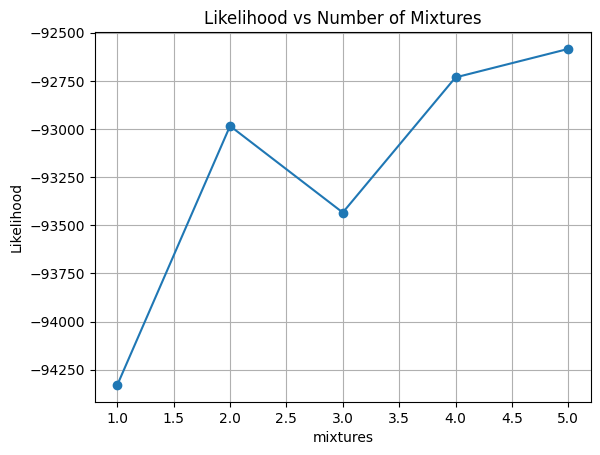

In [ ]:
indices = list(range(1, len(likelis) + 1))
plt.plot(indices, likelis, marker='o', linestyle='-')
plt.xlabel('mixtures')
plt.ylabel('Likelihood')
plt.title('Likelihood vs Number of Mixtures')
plt.grid(True)
plt.show()

**Linear O vs R**

In [ ]:
file_path = '/content/drive/My Drive/prnn_q5.txt'
data = np.loadtxt(file_path, delimiter='\t', skiprows=1)
np.random.shuffle(data)
Y=data[:,25].reshape((-1)).astype(int)
X=data[:,:25]
diff=int(X.shape[0]*0.9)
Xtest=X[diff:,:]
Ytest=Y[diff:]

In [ ]:
def linear(X,Y,L=0):#N,25 N,10
  w=np.linalg.pinv(X.T@X+L*np.identity(X.shape[1]))@X.T@Y
  return w

In [ ]:
EnY=np.zeros((diff,10))
for i in range(diff):
  EnY[i,Y[i]]=1
wt=linear(X[:diff,:],EnY[:diff,:])
wt=wt.T
#---w1--
#---w2--
lincount=0
scores=wt@Xtest.T
predict=np.argmax(scores,axis=0)
confusion=np.zeros((10,10))
clas=np.zeros((10,1))
tp=np.zeros((10,1))
tn=np.zeros((10,1))
fp=np.zeros((10,1))
fn=np.zeros((10,1))
for i in range(X.shape[0]-diff):
  clas[Ytest[i]]+=1
  pred=predict[i]
  truth=Ytest[i]
  confusion[pred,truth]+=1
  if truth==pred:
    tp[truth]+=1
    tn+=1
    tn[truth]-=1
  else:
    fn[truth]+=1
    fp[pred]+=1
    tn+=1
    tn[truth]-=1
    tn[pred]-=1
print("The Analysis of Linear One vs Rest clssifiers is \n")
for i in range(10):
  Tp=tp[i]
  Fp=fp[i]
  Tn=tn[i]
  Fn=fn[i]
  f1=2*Tp/(2*Tp+(Fp+Fn))
  acc=(Tp+Tn)*100/(Tp+Fp+Tn+Fn)
  print(f"total objects of class {i} are: {clas[i]}")
  print(f"F1 score of class {i} is: {f1}")
  print(f"Accuracy of class {i} is: {acc}")
for i in range(10):
  print(confusion[i,:])

The Analysis of Linear One vs Rest clssifiers is 

total objects of class 0 are: [723.]
F1 score of class 0 is: [0.30248307]
Accuracy of class 0 is: [86.75714286]
total objects of class 1 are: [718.]
F1 score of class 1 is: [0.41658342]
Accuracy of class 1 is: [83.31428571]
total objects of class 2 are: [697.]
F1 score of class 2 is: [0.2023919]
Accuracy of class 2 is: [87.61428571]
total objects of class 3 are: [729.]
F1 score of class 3 is: [0.275562]
Accuracy of class 3 is: [85.72857143]
total objects of class 4 are: [704.]
F1 score of class 4 is: [0.34175692]
Accuracy of class 4 is: [84.37142857]
total objects of class 5 are: [664.]
F1 score of class 5 is: [0.16339193]
Accuracy of class 5 is: [88.44285714]
total objects of class 6 are: [694.]
F1 score of class 6 is: [0.35077289]
Accuracy of class 6 is: [84.4]
total objects of class 7 are: [685.]
F1 score of class 7 is: [0.32595573]
Accuracy of class 7 is: [85.64285714]
total objects of class 8 are: [711.]
F1 score of class 8 is: [0

**Parzen Window**

In [ ]:
klist=[3,5,7,10,15,20,25,35]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for kernel in ["soft","cubic"]:
  acclist=[]
  Fonelist=[[],[],[],[],[],[],[],[],[],[]]
  for val in klist:
    clas=np.zeros((10,1))
    tp=np.zeros((10,1))
    tn=np.zeros((10,1))
    fp=np.zeros((10,1))
    fn=np.zeros((10,1))
    confusion=np.zeros((10,10))
    st=np.random.randint(diff, X.shape[0]-300)
    for l in range(st,st+200):
      pred=parzen(X[l],kernel,val)
      truth=Y[l]
      confusion[pred,truth]+=1
      clas[truth]+=1
      if truth==pred:
        tp[truth]+=1
        tn+=1
        tn[truth]-=1
      else:
        fn[truth]+=1
        fp[pred]+=1
        tn+=1
        tn[truth]-=1
        tn[pred]-=1
    print(f"\nThe Analysis of Parzen Window classifier with parameter={val} and kernel={kernel} is \n")
    for i in range(10):
      Tp=tp[i]
      Fp=fp[i]
      Tn=tn[i]
      Fn=fn[i]
      f1=2*Tp/(2*Tp+(Fp+Fn))
      Fonelist[i].append(f1)
      acc=(Tp+Tn)*100/(Tp+Fp+Tn+Fn)
      print(f"total objects of class {i} are: {clas[i]}")
      print(f"F1 score of class {i} is: {f1}")
      print(f"Accuracy of class {i} is: {acc}")
    acclist.append(np.sum(tp))
    for i in range(10):
      print(confusion[i,:])
  plt.plot(klist, acclist, marker='o', linestyle='-')
  plt.xlabel('Index')
  plt.ylabel('Acc')
  plt.title(f'Acc vs K of parzen window with {kernel} Kernel')
  plt.grid(True)
  plt.show()

  # for i, lst in enumerate(Fonelist):
  #   plt.plot(klist, lst, label=f'F1 score for class {i}', color=colors[i])
  # plt.xlabel('K values')
  # plt.ylabel('Scores')
  # plt.title('F1-scores')
  # plt.legend()
  # plt.show()

The outputs are:<br>
Parzen window with Gaussian kernel:<br>
<img src="https://drive.google.com/uc?id=1pImMmBYIbngQ4khEGimDKi1bVRIjmyK4" width=250 height=250>

<img src="https://drive.google.com/uc?id=1z4M0LGuxU6y7l9ulMl05UI9qxeSC1Wry" width=250 height=250>

<img src="https://drive.google.com/uc?id=1BWHVbmFwGlYDxyPuI6Wft1Z7M04g7w5h" width=250 height=250>

<img src="https://drive.google.com/uc?id=1UX8w1PLz7QXtQUHyfN8JlpvDcA2srCO7" width=250 height=250>
<br>
Parzen window with Hypercubic/Cubic kernel:<br>
<img src="https://drive.google.com/uc?id=18Ud0l32jPlTeMGxRZKxw8QrE8O5Fs1Sg" width=250 height=250>

<img src="https://drive.google.com/uc?id=12qPQQpbP7vAiE7eEN7JphA-c1Z_-rRFS" width=250 height=250>

<img src="https://drive.google.com/uc?id=1NCN3yaS96Xy-2x9RxZpVtdOfOx4yLT1M" width=250 height=250>



**KNN**

In [ ]:
for kernel in ["euclidean","cosine"]:
  acclist=[]
  Fonelist=[[],[],[],[],[],[],[],[],[],[]]
  for val in klist:
    clas=np.zeros((10,1))
    tp=np.zeros((10,1))
    tn=np.zeros((10,1))
    fp=np.zeros((10,1))
    fn=np.zeros((10,1))
    confusion=np.zeros((10,10))
    st=np.random.randint(diff, X.shape[0]-300)
    for l in range(st,st+300):
      pred=knn(X[l],val,kernel)
      truth=Y[l]
      confusion[pred,truth]+=1
      clas[truth]+=1
      if truth==pred:
        tp[truth]+=1
        tn+=1
        tn[truth]-=1
      else:
        fn[truth]+=1
        fp[pred]+=1
        tn+=1
        tn[truth]-=1
        tn[pred]-=1
    print(f"\nThe Analysis of KNN classifier with K={val} and distance metric={kernel} \n")
    for i in range(10):
      Tp=tp[i]
      Fp=fp[i]
      Tn=tn[i]
      Fn=fn[i]
      f1=2*Tp/(2*Tp+(Fp+Fn))
      Fonelist[i].append(f1)
      acc=(Tp+Tn)*100/(Tp+Fp+Tn+Fn)
      print(f"total objects of class {i} are: {clas[i]}")
      print(f"F1 score of class {i} is: {f1}")
      print(f"Accuracy of class {i} is: {acc}")
      print(f"{Tp} {Fp}\n{Fn} {Tn}")
    acclist.append(np.sum(tp)/300)
    for i in range(10):
      print(confusion[i,:])
  plt.plot(klist, acclist, marker='o', linestyle='-')
  plt.xlabel('Index')
  plt.ylabel('Acc')
  plt.title(f'Acc vs K of KNN with distance metric={kernel}')
  plt.grid(True)
  plt.show()

  # for i, lst in enumerate(Fonelist):
  #   plt.plot(klist, lst, label=f'F1 score for class {i}', color=colors[i])
  # plt.xlabel('K values')
  # plt.ylabel('Scores')
  # plt.title('F1-scores')
  # plt.legend()
  # plt.show()

the outputs are:<br>
KNN with cosine distance:<br>
<img src="https://drive.google.com/uc?id=111tDEMtpZIAZkc4MgUqLv04TvRQ0TodO"  height=350>

<img src="https://drive.google.com/uc?id=13wjbaRRQhUbWzYIkIWThoc1mMQxbSdn0" height=350>

<img src="https://drive.google.com/uc?id=1u6FzwP7pjhjn5N2gELrqy0QbODB9Vz6l" height=350>

<img src="https://drive.google.com/uc?id=1ZXPC1bek-RgbriaTVgtrrc2hVrI-fuKh" width=250 height=250>
<br>
KNN with Euclidean Distance:<br>
<img src="https://drive.google.com/uc?id=11wlRmMHg8KKTXDo8rEfAY23b8orEaiTL" height=350>

<img src="https://drive.google.com/uc?id=1H3Uc0uNkKq0Lm6PULYNdVOnPB08ykyTf" height=350>

<img src="https://drive.google.com/uc?id=1LP2I8LRgn99maO7rQpSKJONW5Bbu7wsC" height=350>

<img src="https://drive.google.com/uc?id=1OjFtLEAlcyU6pKatGydFE5NV3aFYwC_1" width=250 height=250>

<img src="https://drive.google.com/uc?id=1NUPjn9Twwza-gQQ2pX23zUMR37yOp_MT" width=250 height=250>

<img src="https://drive.google.com/uc?id=1pGIcQ3SGiIwb4X-8C2yhhwSSHZLbG4xH" width=400 height=400>

